In [2]:
# transfer of learning for perturbation, using the idea of backprop + hebbian
# need to first find the optimum weight sum when perturbation, otherwise, the loss would shoot up
# it happens that not giving boundary to perturbation period while giving boundary to non-perturbation period produces the best result
# giving boundary might cause convergence to boundary (high loss), for example, when shifts want to jump below 1
# not giving boundary might sink into a local minimum where the loss is really low but gains and shifts are deviant from initial
# may not be generalizable, a better method for narrowing the boundary??
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
from training_abb05_bphebb import SimpleNeuralNetwork
from tqdm.notebook import tqdm

In [3]:
# load the pickle file
with open('weights_abb05_bphebb.pkl', 'rb') as f:
    model_rep = pickle.load(f)

In [4]:
# input and target
ndata = 200
xs = torch.linspace(0, 2 * torch.pi, ndata)
ys = torch.cos(xs)/4 + 0.5

In [1]:
# # bp on weight to find the hebb alpha for perturbed network
# # init
# input_size = 230
# init_gain = 3 * np.ones((input_size, 1))
# init_shift = 1 * np.ones((input_size, 1))
# init_weight = np.ones((1, input_size)) * 5.5 / input_size

# # Training Loop
# weight_epochs = 200
# backprop_lr = 0.01

# # define noise
# np.random.seed(42)
# W = np.eye(input_size) * 0.001
# x_noises = (np.random.multivariate_normal(mean=np.zeros(input_size), cov=W, size=weight_epochs)).T * 0
# x_noises = torch.tensor(x_noises, dtype=torch.float32)
# x_noises += 0.1

# # record
# weight_losses = []
# weight_sums = []
# # weights = []

# for epoch in tqdm(range(weight_epochs), position=0, leave=True):
    
#     # establish model
#     model = SimpleNeuralNetwork(input_size, init_gain, init_shift, init_weight)

#     # shuffle data
#     perm_idx = torch.randperm(ndata)
#     shuffled_xs = xs[perm_idx]
#     shuffled_ys = ys[perm_idx]
#     epoch_loss = 0

#     # go through all data
#     for x, y in zip(shuffled_xs, shuffled_ys):  
#         # forward
#         inpu_ipl = model.gaussian_rf(x)
#         actv_ipl = model.activation_func(model.gain * (inpu_ipl - model.shift)) + (x_noises[:, epoch]).reshape(-1, 1)
#         # actv_ipl = model.activation_func(model.gain * (inpu_ipl - model.shift))
#         model.input_activation = actv_ipl.clone()
#         inpu_opl = torch.matmul(model.weights, actv_ipl)
#         actv_opl = model.activation_func(model.gainout * (inpu_opl - model.shiftout))
#         model.output_activation = actv_opl.clone()          
#         output = actv_opl.squeeze()
#         # Calculate loss
#         loss_func = nn.MSELoss()
#         loss = 0.5 * loss_func(output, y)
        
#         # backprop
#         optimizer = optim.SGD([model.weights], lr=backprop_lr)
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()

#         epoch_loss += loss.item()

#     # update init
#     init_gain = model.gain.detach().numpy()
#     init_shift = model.shift.detach().numpy()
#     init_weight = model.weights.detach().numpy()

#     # record
#     epoch_loss /= ndata
#     weight_losses.append(epoch_loss)
#     weight_sums.append(np.sum(init_weight))

#     # print out info
#     if epoch % 10 == 0:
#         print(f'Epoch {epoch+1}/{weight_epochs}, Loss: {epoch_loss}, Sum: {np.sum(init_weight)}')


### The Function for Perturbation Analysis

In [44]:
class PerturbNetwork():
     
    def __init__(self, model_rep, simu_epochs=1500, perturb_start=50, perturb_last=500, perturb_amp=0.1, only_backprop_epoch=10,
                 backprop_lr=0.2, hebbian_lr=0.0001, hebb_alpha=5.5):
        # init params
        self.simu_epochs = simu_epochs
        self.perturb_start = perturb_start
        self.perturb_last = perturb_last
        self.perturb_amp = perturb_amp
        self.only_backprop_epoch = only_backprop_epoch
        self.backprop_lr = backprop_lr
        self.hebbian_lr = hebbian_lr
        self.hebb_alpha = hebb_alpha

        # some hard defined params
        self.input_size = 230
        self.theo_gain = 3 * np.ones((self.input_size, 1))
        self.theo_shift = 1 * np.ones((self.input_size, 1))

        # init models
        self.init_gain = model_rep.gain.detach().numpy()
        self.init_shift = model_rep.shift.detach().numpy()
        self.init_weight = model_rep.weights.detach().numpy()

    def simulate(self, ndata=200):
        # set seed
        np.random.seed(42)
        torch.manual_seed(42)

        # data prep
        xs = torch.linspace(0, 2 * torch.pi, ndata)
        ys = torch.cos(xs)/4 + 0.5
    
        # define noise
        W = np.eye(self.input_size) * 0.001
        x_noises = (np.random.multivariate_normal(mean=np.zeros(self.input_size), cov=W, size=self.simu_epochs)).T * 0
        x_noises = torch.tensor(x_noises, dtype=torch.float32)
        x_noises[:,self.perturb_start:self.perturb_start+self.perturb_last] += self.perturb_amp

        # flags
        has_backprop = True  # always true
        has_boundary = False
        has_hebbian = True
        has_perturb = False

        # to record
        simu_losses = []
        gain_changes = []
        shift_changes = []
        weight_sums = []
        epoch_loss = 0

        for epoch in tqdm(range(self.simu_epochs)):
            if epoch == self.perturb_start:
                has_perturb = True
                has_hebbian = False
                has_boundary = False
                # hebbian_lr = 0
                print("perturbation start!!!")
            if epoch == self.perturb_start + self.perturb_last:
                has_perturb = False
                has_hebbian = False
                has_boundary = False
                # hebbian_lr = 0
                print("perturbation end!!!")

            # shuffle data
            ndata = len(xs)
            perm_idx = torch.randperm(ndata)
            shuffled_xs = xs[perm_idx]
            shuffled_ys = ys[perm_idx]
            last_epoch_loss = epoch_loss
            epoch_loss = 0

            # start hebbian and shrinkage
            if has_perturb and epoch > self.perturb_start + self.only_backprop_epoch and last_epoch_loss < 0.001 and has_hebbian == False:
                has_hebbian = True
                print("perturb learning start!!!")
            if not has_perturb and epoch > self.perturb_start + self.perturb_last + self.only_backprop_epoch and last_epoch_loss < 0.001 and has_hebbian == False:
                has_hebbian = True
                print("origin learning start!!!")
            # if has_perturb and epoch > perturb_start + 10 and last_epoch_loss < 0.001 and has_boundary == False:
            #     gain_ub = np.maximum(init_gain, theo_gain) + 0.1
            #     gain_lb = np.minimum(init_gain, theo_gain) - 0.1
            #     shift_ub = np.maximum(init_shift, theo_shift) + 0.1
            #     shift_lb = np.minimum(init_shift, theo_shift) - 0.1
            #     has_boundary = True
            #     print("perturb boundary created!!!")
            if not has_perturb and epoch > self.perturb_start + self.perturb_last + self.only_backprop_epoch and last_epoch_loss < 0.001 and has_boundary == False:
                gain_ub = np.maximum(self.init_gain, self.theo_gain)
                gain_lb = np.minimum(self.init_gain, self.theo_gain)
                shift_ub = np.maximum(self.init_shift, self.theo_shift)
                shift_lb = np.minimum(self.init_shift, self.theo_shift)
                has_boundary = True
                print("origin boundary created!!!")
                
            # # update hebbian learning rate, once per epoch
            # if has_hebbian and hebbian_lr < max_hebbian_lr:
            #     hebbian_lr += hebbian_up_rate
            
            # go through all data
            for x, y in zip(shuffled_xs, shuffled_ys):  
                # establish model
                model = SimpleNeuralNetwork(self.input_size, self.init_gain, self.init_shift, self.init_weight)
                # forward
                inpu_ipl = model.gaussian_rf(x)
                actv_ipl = model.activation_func(model.gain * (inpu_ipl - model.shift)) + (x_noises[:, epoch]).reshape(-1, 1)
                model.input_activation = actv_ipl.clone()
                inpu_opl = torch.matmul(model.weights, actv_ipl)
                actv_opl = model.activation_func(model.gainout * (inpu_opl - model.shiftout))
                model.output_activation = actv_opl.clone()          
                output = actv_opl.squeeze()
                # Calculate loss
                loss_func = nn.MSELoss()
                loss = 0.5 * loss_func(output, y)
                epoch_loss += loss

                # backprop for gains and shifts
                if has_backprop:
                    optimizer = optim.SGD([model.gain, model.shift], lr=self.backprop_lr)
                    loss.backward()
                    optimizer.step()
                    optimizer.zero_grad()
                # update init gains and shifts
                self.init_gain = model.gain.detach().numpy()
                self.init_shift = model.shift.detach().numpy()
                gain_change = np.linalg.norm(self.init_gain - self.theo_gain, 2)
                shift_change = np.linalg.norm(self.init_shift - self.theo_shift, 2)

                # hebbian learning for weights
                if has_hebbian:
                    # Calculate Hebbian weight updates
                    hebbian_update = model.output_activation * (model.input_activation).T
                    # Apply Hebbian updates and normalize
                    model.weights = model.weights + self.hebbian_lr * hebbian_update
                    model.weights = model.weights / torch.sum(model.weights) * self.hebb_alpha
                # update init weights
                self.init_weight = model.weights.detach().numpy()

                # shrink shift and gain to init value
                if has_boundary:
                    # passively narrow the boundaries
                    # if gain_change > 0.1:
                    gain_ub = np.maximum(np.minimum(self.init_gain, gain_ub), self.theo_gain)
                    gain_lb = np.minimum(np.maximum(self.init_gain, gain_lb), self.theo_gain)
                    # if shift_change > 0.1:
                    shift_ub = np.maximum(np.minimum(self.init_shift, shift_ub), self.theo_shift)
                    shift_lb = np.minimum(np.maximum(self.init_shift, shift_lb), self.theo_shift)
                    # pull gains and shifts back to into boundaries
                    self.init_gain = np.minimum(self.init_gain, gain_ub)
                    self.init_gain = np.maximum(self.init_gain, gain_lb)
                    self.init_shift = np.minimum(self.init_shift, shift_ub)
                    self.init_shift = np.maximum(self.init_shift, shift_lb)

            # print losses
            epoch_loss /= ndata
            if epoch % 10 == 0:
                print(f"Epoch: {epoch}, Loss: {epoch_loss}")
            
            # record
            simu_losses.append(epoch_loss.item())
            weight_sums.append(np.sum(self.init_weight))
            gain_changes.append(gain_change)
            shift_changes.append(shift_change)

        return simu_losses, weight_sums, gain_changes, shift_changes, model

### Perturbation 500 Epochs

In [45]:
simulator = PerturbNetwork(model_rep, simu_epochs=2000, only_backprop_epoch=0)
simu_losses, weight_sums, gain_changes, shift_changes, model = simulator.simulate(ndata=200)

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 0, Loss: 4.9279384256806225e-05
Epoch: 10, Loss: 9.733019396662712e-06
Epoch: 20, Loss: 7.063486464176094e-06
Epoch: 30, Loss: 6.709557510475861e-06
Epoch: 40, Loss: 6.484237474069232e-06
perturbation start!!!
Epoch: 50, Loss: 0.11529798805713654
perturb learning start!!!
Epoch: 60, Loss: 0.0004943821695633233
Epoch: 70, Loss: 0.0001341013121418655
Epoch: 80, Loss: 7.499976345570758e-05
Epoch: 90, Loss: 4.286370312911458e-05
Epoch: 100, Loss: 2.3747645172988996e-05
Epoch: 110, Loss: 1.5158198948483914e-05
Epoch: 120, Loss: 1.155093195848167e-05
Epoch: 130, Loss: 9.763328307599295e-06
Epoch: 140, Loss: 8.736805284570437e-06
Epoch: 150, Loss: 8.097999852907378e-06
Epoch: 160, Loss: 7.958232345117722e-06
Epoch: 170, Loss: 7.166741397668375e-06
Epoch: 180, Loss: 6.608960120502161e-06
Epoch: 190, Loss: 6.28590396445361e-06
Epoch: 200, Loss: 5.644494649459375e-06
Epoch: 210, Loss: 5.423853963293368e-06
Epoch: 220, Loss: 5.000899363949429e-06
Epoch: 230, Loss: 4.5763108573737554e-06
Ep

In [95]:
# # perturbation for 2000 epochs
# simu_epochs = 4000
# perturb_start = 50
# perturb_last = 2000
# input_size = 230
# theo_gain = 3 * np.ones((input_size, 1))
# theo_shift = 1 * np.ones((input_size, 1))
# init_gain = model_rep.gain.detach().numpy()
# init_shift = model_rep.shift.detach().numpy()
# init_weight = model_rep.weights.detach().numpy()
# hebbian_lr = 0.0001
# max_hebbian_lr = 0.0001
# hebbian_up_rate = max_hebbian_lr / 100
# hebb_alpha = 5.5
# hebb_alpha_origin = 5.5
# hebb_alpha_perturb = 5.5  # 3.5
# hebb_alpha_up_rate = (hebb_alpha_perturb - hebb_alpha) / 100
# backprop_lr = 0.2
# has_backprop = True
# has_boundary = False
# has_hebbian = True
# has_perturb = False

# # define noise
# np.random.seed(42)
# W = np.eye(input_size) * 0.001
# x_noises = (np.random.multivariate_normal(mean=np.zeros(input_size), cov=W, size=simu_epochs)).T * 0
# x_noises = torch.tensor(x_noises, dtype=torch.float32)
# x_noises[:,perturb_start:perturb_start+perturb_last] += 0.1

# simu_losses = []
# gain_changes = []
# shift_changes = []
# weight_sums = []
# epoch_loss = 0

# for epoch in tqdm(range(simu_epochs), position=0, leave=True):
#     if epoch == perturb_start:
#         has_perturb = True
#         has_hebbian = False
#         has_boundary = False
#         hebbian_lr = 0
#         print("perturbation start!!!")
#     if epoch == perturb_start + perturb_last:
#         has_perturb = False
#         has_hebbian = False
#         has_boundary = False
#         hebbian_lr = 0
#         print("perturbation end!!!")
   
#     # shuffle data
#     perm_idx = torch.randperm(ndata)
#     shuffled_xs = xs[perm_idx]
#     shuffled_ys = ys[perm_idx]
#     last_epoch_loss = epoch_loss
#     epoch_loss = 0

#     # start hebbian and shrinkage
#     if has_perturb and epoch > perturb_start + 10 and last_epoch_loss < 0.001 and has_hebbian == False:
#         has_hebbian = True
#         print("perturb learning start!!!")
#     if not has_perturb and epoch > perturb_start + perturb_last + 10 and last_epoch_loss < 0.001 and has_hebbian == False:
#         has_hebbian = True
#         print("origin learning start!!!")
#     # if has_perturb and epoch > perturb_start + 10 and last_epoch_loss < 0.001 and has_boundary == False:
#     #     gain_ub = np.maximum(init_gain, theo_gain) + 0.1
#     #     gain_lb = np.minimum(init_gain, theo_gain) - 0.1
#     #     shift_ub = np.maximum(init_shift, theo_shift) + 0.1
#     #     shift_lb = np.minimum(init_shift, theo_shift) - 0.1
#     #     has_boundary = True
#     #     print("perturb boundary created!!!")
#     if not has_perturb and epoch > perturb_start + perturb_last + 10 and last_epoch_loss < 0.001 and has_boundary == False:
#         gain_ub = np.maximum(init_gain, theo_gain)
#         gain_lb = np.minimum(init_gain, theo_gain)
#         shift_ub = np.maximum(init_shift, theo_shift)
#         shift_lb = np.minimum(init_shift, theo_shift)
#         has_boundary = True
#         print("origin boundary created!!!")
        
#     # update hebbian learning rate, once per epoch
#     if has_hebbian and hebbian_lr < max_hebbian_lr:
#         hebbian_lr += hebbian_up_rate
#     if has_hebbian and has_perturb and hebb_alpha > hebb_alpha_perturb:
#         hebb_alpha += hebb_alpha_up_rate
#     if has_hebbian and not has_perturb and hebb_alpha < hebb_alpha_origin:
#         hebb_alpha -= hebb_alpha_up_rate
    
#     # go through all data
#     for x, y in zip(shuffled_xs, shuffled_ys):  
#         # establish model
#         model = SimpleNeuralNetwork(input_size, init_gain, init_shift, init_weight)
#         # forward
#         inpu_ipl = model.gaussian_rf(x)
#         actv_ipl = model.activation_func(model.gain * (inpu_ipl - model.shift)) + (x_noises[:, epoch]).reshape(-1, 1)
#         # actv_ipl = model.activation_func(model.gain * (inpu_ipl - model.shift))
#         model.input_activation = actv_ipl.clone()
#         inpu_opl = torch.matmul(model.weights, actv_ipl)
#         actv_opl = model.activation_func(model.gainout * (inpu_opl - model.shiftout))
#         model.output_activation = actv_opl.clone()          
#         output = actv_opl.squeeze()
#         # Calculate loss
#         loss_func = nn.MSELoss()
#         loss = 0.5 * loss_func(output, y)
#         epoch_loss += loss

#         # backprop for gains and shifts
#         if has_backprop:
#             optimizer = optim.SGD([model.gain, model.shift], lr=backprop_lr)
#             loss.backward()
#             optimizer.step()
#             optimizer.zero_grad()
#         # update init gains and shifts
#         init_gain = model.gain.detach().numpy()
#         init_shift = model.shift.detach().numpy()
#         gain_change = np.linalg.norm(init_gain - theo_gain, 2)
#         shift_change = np.linalg.norm(init_shift - theo_shift, 2)

#         # hebbian learning for weights
#         if has_hebbian:
#             # Calculate Hebbian weight updates
#             hebbian_update = model.output_activation * (model.input_activation).T
#             # Apply Hebbian updates and normalize
#             model.weights = model.weights + hebbian_lr * hebbian_update
#             model.weights = model.weights / torch.sum(model.weights) * hebb_alpha
#         # update init weights
#         init_weight = model.weights.detach().numpy()

#         # shrink shift and gain to init value
#         if has_boundary:
#             # passively narrow the boundaries
#             # gain_ub = np.maximum(np.minimum(init_gain, gain_ub), theo_gain)
#             # gain_lb = np.minimum(np.maximum(init_gain, gain_lb), theo_gain)
#             # shift_ub = np.maximum(np.minimum(init_shift, shift_ub), theo_shift)
#             # shift_lb = np.minimum(np.maximum(init_shift, shift_lb), theo_shift)
#             # pull gains and shifts back to into boundaries
#             init_gain = np.minimum(init_gain, gain_ub)
#             init_gain = np.maximum(init_gain, gain_lb)
#             init_shift = np.minimum(init_shift, shift_ub)
#             init_shift = np.maximum(init_shift, shift_lb)

#     # print losses
#     epoch_loss /= ndata
#     if epoch % 20 == 0:
#         print(f"Epoch: {epoch}, Loss: {epoch_loss}")
#         # print(f"Gains: {init_gain[0:10].flatten()}")
#         # print(f"Shifts: {init_shift[0:10].flatten()}")

#     # record
#     simu_losses.append(epoch_loss.item())
#     weight_sums.append(np.sum(init_weight))
#     gain_changes.append(gain_change)
#     shift_changes.append(shift_change)

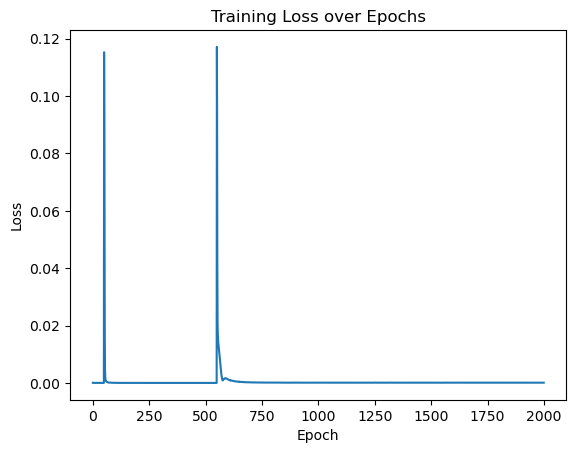

In [46]:
# Plotting the loss
plt.plot(range(len(simu_losses)), simu_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim([0,0.01])
plt.title('Training Loss over Epochs')
# plt.savefig('abb05_loss.png')
plt.show()

In [47]:
# input and target
ndata = 200
xs = torch.linspace(0, 2 * torch.pi, ndata)
ys = torch.cos(xs)/4 + 0.5

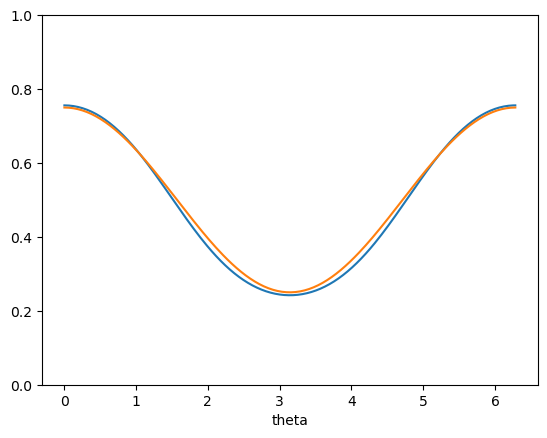

In [48]:
# Plotting the outputs
model.eval()
outputs = []
for x in xs:
    output = model(x)
    outputs.append(output.item())
plt.plot(xs, outputs)
plt.plot(xs, ys, label='target')
plt.ylim([0,1])
plt.xlabel("theta")
# plt.savefig('abb05_outputs.png')
plt.show()

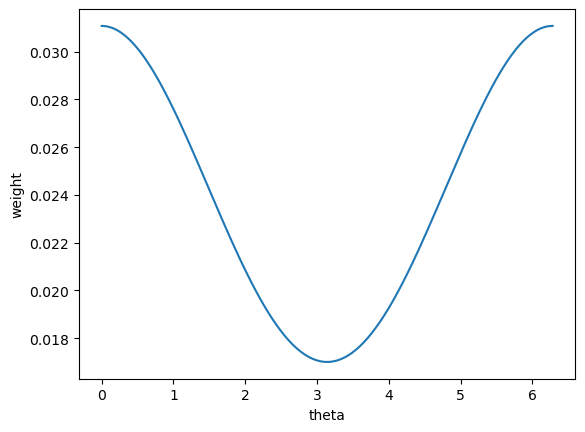

In [49]:
final_weight = model.weights.detach().numpy()
plt.plot(np.linspace(0, 2 * np.pi, model.input_size), final_weight.flatten())
# plt.ylim([0,8])
plt.xlabel("theta")
plt.ylabel("weight")
# plt.savefig('abb05_ws.png')
plt.show()

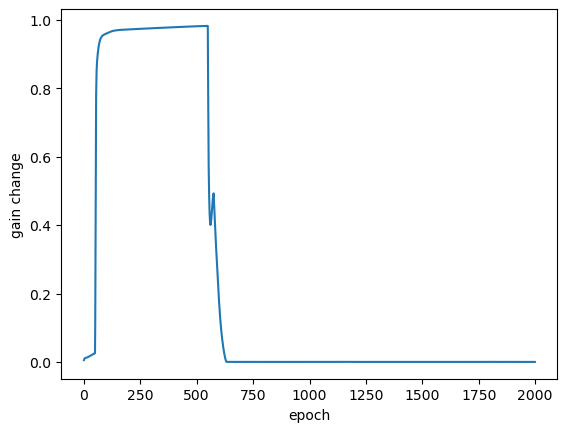

In [50]:
plt.plot(np.arange(len(simu_losses)), gain_changes)
plt.xlabel("epoch")
plt.ylabel("gain change")
# plt.hlines(y=np.sqrt(460)*0.1, xmin=0, xmax=epochs)
# plt.savefig('abb05_gc.png')
plt.show()

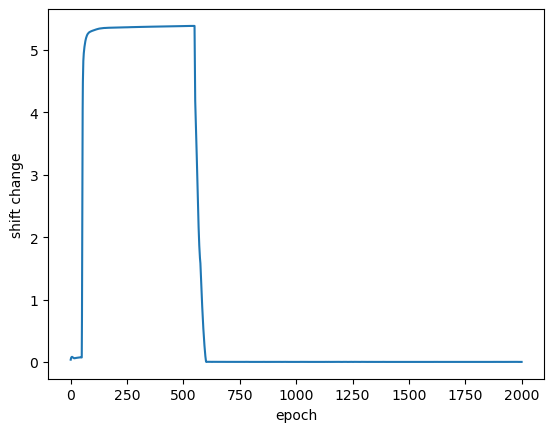

In [51]:
plt.plot(np.arange(len(simu_losses)), shift_changes)
plt.xlabel("epoch")
plt.ylabel("shift change")
# plt.hlines(y=np.sqrt(460)*0.1, xmin=0, xmax=epochs)
# plt.savefig('abb05_sc.png')
plt.show()

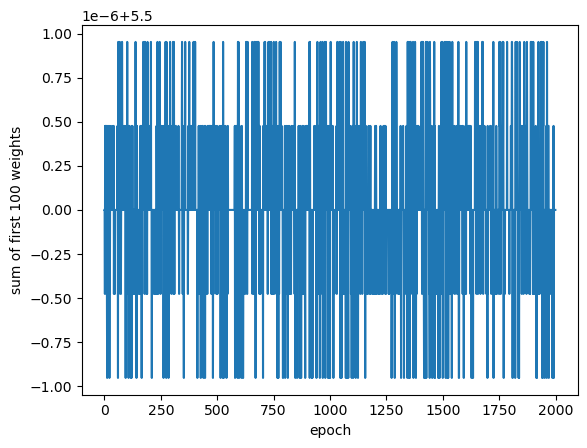

In [52]:
plt.plot(np.arange(len(simu_losses)), weight_sums)
# plt.ylim([0,8])
plt.xlabel("epoch")
plt.ylabel("sum of first 100 weights")
# plt.savefig('abb05_ws.png')
plt.show()

In [53]:
rates = []
for x in xs:
    input = model.gaussian_rf(x)
    rate = model.activation_func(model.gain * (input - model.shift))
    rates.append(rate)
rates = torch.cat(rates, dim=1)
rates = rates.detach().numpy().round(4)
rates

array([[0.5   , 0.4996, 0.4985, ..., 0.4985, 0.4996, 0.5   ],
       [0.4997, 0.5   , 0.4995, ..., 0.4969, 0.4987, 0.4997],
       [0.4989, 0.4998, 0.5   , ..., 0.4948, 0.4972, 0.4989],
       ...,
       [0.4989, 0.4972, 0.4948, ..., 0.5   , 0.4998, 0.4989],
       [0.4997, 0.4987, 0.4969, ..., 0.4995, 0.5   , 0.4997],
       [0.5   , 0.4996, 0.4985, ..., 0.4985, 0.4996, 0.5   ]],
      dtype=float32)

Text(0, 0.5, 'firing rate')

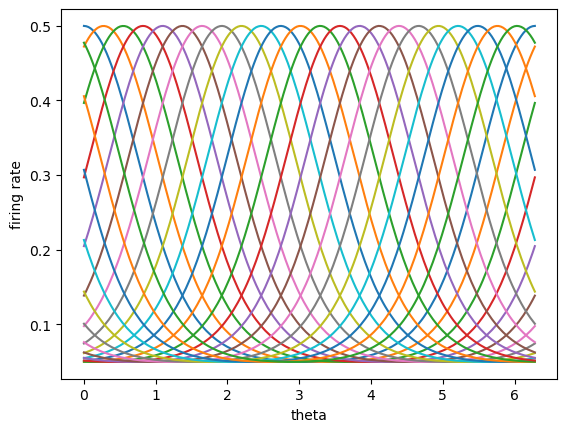

In [54]:
for i in np.arange(0,model.input_size,10):
    thisr = rates[i,:]
    plt.plot(xs, thisr)
plt.xlabel("theta")
plt.ylabel("firing rate")
# plt.savefig('abb05_rf.png')

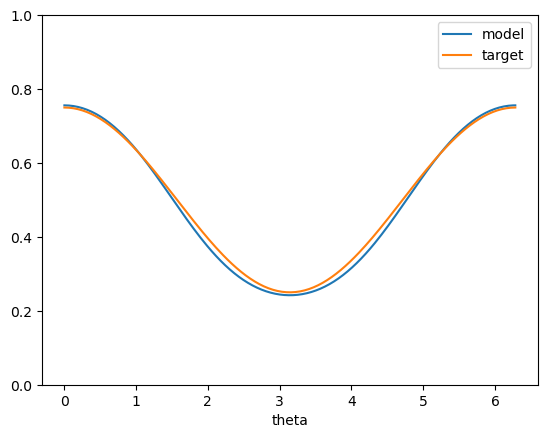

In [55]:
# Plotting the outputs
model.gain = model.init_gain
model.shift = model.init_shift
model.eval()
outputs = []
for x in xs:
    output = model(x)
    outputs.append(output.item())
plt.plot(xs, outputs, label='model')
plt.plot(xs, ys, label='target')
plt.ylim([0,1])
plt.xlabel("theta")
plt.legend()
# plt.savefig('abb05_outputs_nosup.png')

### Different Perturbation Lasts

In [ ]:
# # manual simulation
# perturb_lasts = [1000, 2000, 5000]

# all_simu_losses = []
# all_gain_changes = []
# all_shift_changes = []
# all_weight_sums = []

# for perturb_last in perturb_lasts:

#     print(f"perturb_last: {perturb_last}")

#     simu_epochs = 8000
#     perturb_start = 50
#     # perturb_last = 500
#     input_size = 230
#     theo_gain = 3 * np.ones((input_size, 1))
#     theo_shift = 1 * np.ones((input_size, 1))
#     init_gain = model_rep.gain.detach().numpy()
#     init_shift = model_rep.shift.detach().numpy()
#     init_weight = model_rep.weights.detach().numpy()
#     hebbian_lr = 0.0001
#     max_hebbian_lr = 0.0001
#     hebbian_up_rate = max_hebbian_lr / 100
#     hebb_alpha = 5.5
#     hebb_alpha_origin = 5.5
#     hebb_alpha_perturb = 5.5
#     hebb_alpha_up_rate = (hebb_alpha_perturb - hebb_alpha) / 100
#     backprop_lr = 0.2
#     has_backprop = True
#     has_boundary = False
#     has_hebbian = True
#     has_perturb = False

#     # define noise
#     np.random.seed(42)
#     W = np.eye(input_size) * 0.001
#     x_noises = (np.random.multivariate_normal(mean=np.zeros(input_size), cov=W, size=simu_epochs)).T * 0
#     x_noises = torch.tensor(x_noises, dtype=torch.float32)
#     x_noises[:,perturb_start:perturb_start+perturb_last] += 0.1

#     simu_losses = []
#     gain_changes = []
#     shift_changes = []
#     weight_sums = []
#     epoch_loss = 0

#     for epoch in tqdm(range(simu_epochs), position=0, leave=True):
#         if epoch == perturb_start:
#             has_perturb = True
#             has_hebbian = False
#             has_boundary = False
#             hebbian_lr = 0
#             print("perturbation start!!!")
#         if epoch == perturb_start + perturb_last:
#             has_perturb = False
#             has_hebbian = False
#             has_boundary = False
#             hebbian_lr = 0
#             print("perturbation end!!!")
        
#         # shuffle data
#         perm_idx = torch.randperm(ndata)
#         shuffled_xs = xs[perm_idx]
#         shuffled_ys = ys[perm_idx]
#         last_epoch_loss = epoch_loss
#         epoch_loss = 0

#         # start hebbian and shrinkage
#         if has_perturb and epoch > perturb_start + 10 and last_epoch_loss < 0.001 and has_hebbian == False:
#             has_hebbian = True
#             print("perturb learning start!!!")
#         if not has_perturb and epoch > perturb_start + perturb_last + 10 and last_epoch_loss < 0.001 and has_hebbian == False:
#             has_hebbian = True
#             print("origin learning start!!!")
#         # if has_perturb and epoch > perturb_start + 10 and last_epoch_loss < 0.001 and has_boundary == False:
#         #     gain_ub = np.maximum(init_gain, theo_gain)
#         #     gain_lb = np.minimum(init_gain, theo_gain)
#         #     shift_ub = np.maximum(init_shift, theo_shift)
#         #     shift_lb = np.minimum(init_shift, theo_shift)
#         #     has_boundary = True
#         #     print("perturb boundary created!!!")
#         if not has_perturb and epoch > perturb_start + perturb_last + 10 and last_epoch_loss < 0.001 and has_boundary == False:
#             gain_ub = np.maximum(init_gain, theo_gain)
#             gain_lb = np.minimum(init_gain, theo_gain)
#             shift_ub = np.maximum(init_shift, theo_shift)
#             shift_lb = np.minimum(init_shift, theo_shift)
#             has_boundary = True
#             print("origin boundary created!!!")
     
#         # update hebbian learning rate, once per epoch
#         if has_hebbian and hebbian_lr < max_hebbian_lr:
#             hebbian_lr += hebbian_up_rate
#         if has_hebbian and has_perturb and hebb_alpha > hebb_alpha_perturb:
#             hebb_alpha += hebb_alpha_up_rate
#         if has_hebbian and not has_perturb and hebb_alpha < hebb_alpha_origin:
#             hebb_alpha -= hebb_alpha_up_rate
        
#         # go through all data
#         for x, y in zip(shuffled_xs, shuffled_ys):  
#             # establish model
#             model = SimpleNeuralNetwork(input_size, init_gain, init_shift, init_weight)
#             # forward
#             inpu_ipl = model.gaussian_rf(x)
#             actv_ipl = model.activation_func(model.gain * (inpu_ipl - model.shift)) + (x_noises[:, epoch]).reshape(-1, 1)
#             # actv_ipl = model.activation_func(model.gain * (inpu_ipl - model.shift))
#             model.input_activation = actv_ipl.clone()
#             inpu_opl = torch.matmul(model.weights, actv_ipl)
#             actv_opl = model.activation_func(model.gainout * (inpu_opl - model.shiftout))
#             model.output_activation = actv_opl.clone()          
#             output = actv_opl.squeeze()
#             # Calculate loss
#             loss_func = nn.MSELoss()
#             loss = 0.5 * loss_func(output, y)
#             epoch_loss += loss

#             # backprop for gains and shifts
#             if has_backprop:
#                 optimizer = optim.SGD([model.gain, model.shift], lr=backprop_lr)
#                 loss.backward()
#                 optimizer.step()
#                 optimizer.zero_grad()
#             # update init gains and shifts
#             init_gain = model.gain.detach().numpy()
#             init_shift = model.shift.detach().numpy()
#             gain_change = np.linalg.norm(init_gain - theo_gain, 2)
#             shift_change = np.linalg.norm(init_shift - theo_shift, 2)

#             # hebbian learning for weights
#             if has_hebbian:
#                 # Calculate Hebbian weight updates
#                 hebbian_update = model.output_activation * (model.input_activation).T
#                 # Apply Hebbian updates and normalize
#                 model.weights = model.weights + hebbian_lr * hebbian_update
#                 model.weights = model.weights / torch.sum(model.weights) * hebb_alpha
#             # update init weights
#             init_weight = model.weights.detach().numpy()

#             # shrink shift and gain to init value
#             if has_boundary:
#                 # passively narrow the boundaries
#                 # gain_ub = np.maximum(np.minimum(init_gain, gain_ub), theo_gain)
#                 # gain_lb = np.minimum(np.maximum(init_gain, gain_lb), theo_gain)
#                 # shift_ub = np.maximum(np.minimum(init_shift, shift_ub), theo_shift)
#                 # shift_lb = np.minimum(np.maximum(init_shift, shift_lb), theo_shift)
#                 # pull gains and shifts back to into boundaries
#                 init_gain = np.minimum(init_gain, gain_ub)
#                 init_gain = np.maximum(init_gain, gain_lb)
#                 init_shift = np.minimum(init_shift, shift_ub)
#                 init_shift = np.maximum(init_shift, shift_lb)

#         # print losses
#         epoch_loss /= ndata
#         if epoch % 100 == 0:
#             print(f"Epoch: {epoch}, Loss: {epoch_loss}")

#         # record
#         simu_losses.append(epoch_loss.item())
#         weight_sums.append(np.sum(init_weight))
#         gain_changes.append(gain_change)
#         shift_changes.append(shift_change)
    
#     # record
#     all_simu_losses.append(simu_losses)
#     all_gain_changes.append(gain_changes)
#     all_shift_changes.append(shift_changes)
#     all_weight_sums.append(weight_sums)

In [56]:
# systematic perturbation tests
perturb_lasts_exp = np.arange(1,3.3,0.2)
perturb_lasts = np.power(10, perturb_lasts_exp).astype(int)

# to record
all_simu_losses = []
all_gain_changes = []
all_shift_changes = []
all_weight_sums = []
simu_epochs = 2000

for perturb_last in perturb_lasts:
    simulator = PerturbNetwork(model_rep, simu_epochs=simu_epochs, perturb_last=perturb_last, only_backprop_epoch=0)
    simu_losses, weight_sums, gain_changes, shift_changes, model = simulator.simulate(ndata=200)
    all_simu_losses.append(simu_losses)
    all_gain_changes.append(gain_changes)
    all_shift_changes.append(shift_changes)
    all_weight_sums.append(weight_sums)

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 0, Loss: 4.9279384256806225e-05
Epoch: 10, Loss: 9.733019396662712e-06
Epoch: 20, Loss: 7.063486464176094e-06
Epoch: 30, Loss: 6.709557510475861e-06
Epoch: 40, Loss: 6.484237474069232e-06
perturbation start!!!
Epoch: 50, Loss: 0.11529798805713654
perturb learning start!!!
perturbation end!!!
Epoch: 60, Loss: 0.1191290020942688
Epoch: 70, Loss: 0.007379578892141581
origin learning start!!!
origin boundary created!!!
Epoch: 80, Loss: 0.0007102370727807283
Epoch: 90, Loss: 0.00015510433877352625
Epoch: 100, Loss: 0.00013120254152454436
Epoch: 110, Loss: 0.00013994620530866086
Epoch: 120, Loss: 0.00011155870743095875
Epoch: 130, Loss: 0.00010703129373723641
Epoch: 140, Loss: 0.00010356200073147193
Epoch: 150, Loss: 0.00010981180821545422
Epoch: 160, Loss: 0.0001060704598785378
Epoch: 170, Loss: 9.624483936931938e-05
Epoch: 180, Loss: 9.464302274864167e-05
Epoch: 190, Loss: 0.00010591579484753311
Epoch: 200, Loss: 0.00010247898899251595
Epoch: 210, Loss: 9.895687981043011e-05
Epoch: 

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 0, Loss: 4.9279384256806225e-05
Epoch: 10, Loss: 9.733019396662712e-06
Epoch: 20, Loss: 7.063486464176094e-06
Epoch: 30, Loss: 6.709557510475861e-06
Epoch: 40, Loss: 6.484237474069232e-06
perturbation start!!!
Epoch: 50, Loss: 0.11529798805713654
perturb learning start!!!
Epoch: 60, Loss: 0.0004943821695633233
perturbation end!!!
Epoch: 70, Loss: 0.01393683161586523
Epoch: 80, Loss: 0.0041899001225829124
origin learning start!!!
origin boundary created!!!
Epoch: 90, Loss: 0.0004073289455845952
Epoch: 100, Loss: 0.00013118139759171754
Epoch: 110, Loss: 0.00014208680659066886
Epoch: 120, Loss: 0.00011253068078076467
Epoch: 130, Loss: 0.00010611998004605994
Epoch: 140, Loss: 0.00010120429215021431
Epoch: 150, Loss: 0.00010655906226020306
Epoch: 160, Loss: 0.0001020833442453295
Epoch: 170, Loss: 9.156409942079335e-05
Epoch: 180, Loss: 8.957986574387178e-05
Epoch: 190, Loss: 0.0001006410748232156
Epoch: 200, Loss: 9.700283408164978e-05
Epoch: 210, Loss: 9.325260180048645e-05
Epoch: 2

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 0, Loss: 4.9279384256806225e-05
Epoch: 10, Loss: 9.733019396662712e-06
Epoch: 20, Loss: 7.063486464176094e-06
Epoch: 30, Loss: 6.709557510475861e-06
Epoch: 40, Loss: 6.484237474069232e-06
perturbation start!!!
Epoch: 50, Loss: 0.11529798805713654
perturb learning start!!!
Epoch: 60, Loss: 0.0004943821695633233
Epoch: 70, Loss: 0.0001341013121418655
perturbation end!!!
Epoch: 80, Loss: 0.01551145315170288
Epoch: 90, Loss: 0.005916066002100706
origin learning start!!!
origin boundary created!!!
Epoch: 100, Loss: 0.0005652459221892059
Epoch: 110, Loss: 0.00021063948224764317
Epoch: 120, Loss: 0.000152272405102849
Epoch: 130, Loss: 0.00013932460569776595
Epoch: 140, Loss: 0.0001274892856599763
Epoch: 150, Loss: 0.00012781664554495364
Epoch: 160, Loss: 0.00011807005648734048
Epoch: 170, Loss: 0.00010300277062924579
Epoch: 180, Loss: 9.810376650420949e-05
Epoch: 190, Loss: 0.00010805923375301063
Epoch: 200, Loss: 0.00010253210348309949
Epoch: 210, Loss: 9.69553948380053e-05
Epoch: 220

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 0, Loss: 4.9279384256806225e-05
Epoch: 10, Loss: 9.733019396662712e-06
Epoch: 20, Loss: 7.063486464176094e-06
Epoch: 30, Loss: 6.709557510475861e-06
Epoch: 40, Loss: 6.484237474069232e-06
perturbation start!!!
Epoch: 50, Loss: 0.11529798805713654
perturb learning start!!!
Epoch: 60, Loss: 0.0004943821695633233
Epoch: 70, Loss: 0.0001341013121418655
Epoch: 80, Loss: 7.499976345570758e-05
perturbation end!!!
Epoch: 90, Loss: 0.0897655040025711
Epoch: 100, Loss: 0.010425563901662827
Epoch: 110, Loss: 0.0018310334999114275
origin learning start!!!
origin boundary created!!!
Epoch: 120, Loss: 0.0005094856605865061
Epoch: 130, Loss: 0.000307134265312925
Epoch: 140, Loss: 0.0002619137230794877
Epoch: 150, Loss: 0.00023907750437501818
Epoch: 160, Loss: 0.00020720182510558516
Epoch: 170, Loss: 0.0001740133884595707
Epoch: 180, Loss: 0.00015705231635365635
Epoch: 190, Loss: 0.00016165066335815936
Epoch: 200, Loss: 0.00014813424786552787
Epoch: 210, Loss: 0.00013546698028221726
Epoch: 220,

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 0, Loss: 4.9279384256806225e-05
Epoch: 10, Loss: 9.733019396662712e-06
Epoch: 20, Loss: 7.063486464176094e-06
Epoch: 30, Loss: 6.709557510475861e-06
Epoch: 40, Loss: 6.484237474069232e-06
perturbation start!!!
Epoch: 50, Loss: 0.11529798805713654
perturb learning start!!!
Epoch: 60, Loss: 0.0004943821695633233
Epoch: 70, Loss: 0.0001341013121418655
Epoch: 80, Loss: 7.499976345570758e-05
Epoch: 90, Loss: 4.286370312911458e-05
Epoch: 100, Loss: 2.3747645172988996e-05
Epoch: 110, Loss: 1.5158198948483914e-05
perturbation end!!!
Epoch: 120, Loss: 0.013623535633087158
Epoch: 130, Loss: 0.004730559419840574
origin learning start!!!
origin boundary created!!!
Epoch: 140, Loss: 0.0009089680970646441
Epoch: 150, Loss: 0.0007710651261731982
Epoch: 160, Loss: 0.0005306299426592886
Epoch: 170, Loss: 0.0004162573313806206
Epoch: 180, Loss: 0.0003478130965959281
Epoch: 190, Loss: 0.00032397129689343274
Epoch: 200, Loss: 0.00028050888795405626
Epoch: 210, Loss: 0.00024336269416380674
Epoch: 22

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 0, Loss: 4.9279384256806225e-05
Epoch: 10, Loss: 9.733019396662712e-06
Epoch: 20, Loss: 7.063486464176094e-06
Epoch: 30, Loss: 6.709557510475861e-06
Epoch: 40, Loss: 6.484237474069232e-06
perturbation start!!!
Epoch: 50, Loss: 0.11529798805713654
perturb learning start!!!
Epoch: 60, Loss: 0.0004943821695633233
Epoch: 70, Loss: 0.0001341013121418655
Epoch: 80, Loss: 7.499976345570758e-05
Epoch: 90, Loss: 4.286370312911458e-05
Epoch: 100, Loss: 2.3747645172988996e-05
Epoch: 110, Loss: 1.5158198948483914e-05
Epoch: 120, Loss: 1.155093195848167e-05
Epoch: 130, Loss: 9.763328307599295e-06
Epoch: 140, Loss: 8.736805284570437e-06
perturbation end!!!
Epoch: 150, Loss: 0.0919562429189682
Epoch: 160, Loss: 0.010218210518360138
Epoch: 170, Loss: 0.0022403551265597343
origin learning start!!!
origin boundary created!!!
Epoch: 180, Loss: 0.0010047968244180083
Epoch: 190, Loss: 0.0008274218998849392
Epoch: 200, Loss: 0.000591357471421361
Epoch: 210, Loss: 0.0004728931235149503
Epoch: 220, Los

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 0, Loss: 4.9279384256806225e-05
Epoch: 10, Loss: 9.733019396662712e-06
Epoch: 20, Loss: 7.063486464176094e-06
Epoch: 30, Loss: 6.709557510475861e-06
Epoch: 40, Loss: 6.484237474069232e-06
perturbation start!!!
Epoch: 50, Loss: 0.11529798805713654
perturb learning start!!!
Epoch: 60, Loss: 0.0004943821695633233
Epoch: 70, Loss: 0.0001341013121418655
Epoch: 80, Loss: 7.499976345570758e-05
Epoch: 90, Loss: 4.286370312911458e-05
Epoch: 100, Loss: 2.3747645172988996e-05
Epoch: 110, Loss: 1.5158198948483914e-05
Epoch: 120, Loss: 1.155093195848167e-05
Epoch: 130, Loss: 9.763328307599295e-06
Epoch: 140, Loss: 8.736805284570437e-06
Epoch: 150, Loss: 8.097999852907378e-06
Epoch: 160, Loss: 7.958232345117722e-06
Epoch: 170, Loss: 7.166741397668375e-06
Epoch: 180, Loss: 6.608960120502161e-06
Epoch: 190, Loss: 6.28590396445361e-06
Epoch: 200, Loss: 5.644494649459375e-06
perturbation end!!!
Epoch: 210, Loss: 0.040918078273534775
Epoch: 220, Loss: 0.00932039599865675
Epoch: 230, Loss: 0.001820

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 0, Loss: 4.9279384256806225e-05
Epoch: 10, Loss: 9.733019396662712e-06
Epoch: 20, Loss: 7.063486464176094e-06
Epoch: 30, Loss: 6.709557510475861e-06
Epoch: 40, Loss: 6.484237474069232e-06
perturbation start!!!
Epoch: 50, Loss: 0.11529798805713654
perturb learning start!!!
Epoch: 60, Loss: 0.0004943821695633233
Epoch: 70, Loss: 0.0001341013121418655
Epoch: 80, Loss: 7.499976345570758e-05
Epoch: 90, Loss: 4.286370312911458e-05
Epoch: 100, Loss: 2.3747645172988996e-05
Epoch: 110, Loss: 1.5158198948483914e-05
Epoch: 120, Loss: 1.155093195848167e-05
Epoch: 130, Loss: 9.763328307599295e-06
Epoch: 140, Loss: 8.736805284570437e-06
Epoch: 150, Loss: 8.097999852907378e-06
Epoch: 160, Loss: 7.958232345117722e-06
Epoch: 170, Loss: 7.166741397668375e-06
Epoch: 180, Loss: 6.608960120502161e-06
Epoch: 190, Loss: 6.28590396445361e-06
Epoch: 200, Loss: 5.644494649459375e-06
Epoch: 210, Loss: 5.423853963293368e-06
Epoch: 220, Loss: 5.000899363949429e-06
Epoch: 230, Loss: 4.5763108573737554e-06
Ep

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 0, Loss: 4.9279384256806225e-05
Epoch: 10, Loss: 9.733019396662712e-06
Epoch: 20, Loss: 7.063486464176094e-06
Epoch: 30, Loss: 6.709557510475861e-06
Epoch: 40, Loss: 6.484237474069232e-06
perturbation start!!!
Epoch: 50, Loss: 0.11529798805713654
perturb learning start!!!
Epoch: 60, Loss: 0.0004943821695633233
Epoch: 70, Loss: 0.0001341013121418655
Epoch: 80, Loss: 7.499976345570758e-05
Epoch: 90, Loss: 4.286370312911458e-05
Epoch: 100, Loss: 2.3747645172988996e-05
Epoch: 110, Loss: 1.5158198948483914e-05
Epoch: 120, Loss: 1.155093195848167e-05
Epoch: 130, Loss: 9.763328307599295e-06
Epoch: 140, Loss: 8.736805284570437e-06
Epoch: 150, Loss: 8.097999852907378e-06
Epoch: 160, Loss: 7.958232345117722e-06
Epoch: 170, Loss: 7.166741397668375e-06
Epoch: 180, Loss: 6.608960120502161e-06
Epoch: 190, Loss: 6.28590396445361e-06
Epoch: 200, Loss: 5.644494649459375e-06
Epoch: 210, Loss: 5.423853963293368e-06
Epoch: 220, Loss: 5.000899363949429e-06
Epoch: 230, Loss: 4.5763108573737554e-06
Ep

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 0, Loss: 4.9279384256806225e-05
Epoch: 10, Loss: 9.733019396662712e-06
Epoch: 20, Loss: 7.063486464176094e-06
Epoch: 30, Loss: 6.709557510475861e-06
Epoch: 40, Loss: 6.484237474069232e-06
perturbation start!!!
Epoch: 50, Loss: 0.11529798805713654
perturb learning start!!!
Epoch: 60, Loss: 0.0004943821695633233
Epoch: 70, Loss: 0.0001341013121418655
Epoch: 80, Loss: 7.499976345570758e-05
Epoch: 90, Loss: 4.286370312911458e-05
Epoch: 100, Loss: 2.3747645172988996e-05
Epoch: 110, Loss: 1.5158198948483914e-05
Epoch: 120, Loss: 1.155093195848167e-05
Epoch: 130, Loss: 9.763328307599295e-06
Epoch: 140, Loss: 8.736805284570437e-06
Epoch: 150, Loss: 8.097999852907378e-06
Epoch: 160, Loss: 7.958232345117722e-06
Epoch: 170, Loss: 7.166741397668375e-06
Epoch: 180, Loss: 6.608960120502161e-06
Epoch: 190, Loss: 6.28590396445361e-06
Epoch: 200, Loss: 5.644494649459375e-06
Epoch: 210, Loss: 5.423853963293368e-06
Epoch: 220, Loss: 5.000899363949429e-06
Epoch: 230, Loss: 4.5763108573737554e-06
Ep

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 0, Loss: 4.9279384256806225e-05
Epoch: 10, Loss: 9.733019396662712e-06
Epoch: 20, Loss: 7.063486464176094e-06
Epoch: 30, Loss: 6.709557510475861e-06
Epoch: 40, Loss: 6.484237474069232e-06
perturbation start!!!
Epoch: 50, Loss: 0.11529798805713654
perturb learning start!!!
Epoch: 60, Loss: 0.0004943821695633233
Epoch: 70, Loss: 0.0001341013121418655
Epoch: 80, Loss: 7.499976345570758e-05
Epoch: 90, Loss: 4.286370312911458e-05
Epoch: 100, Loss: 2.3747645172988996e-05
Epoch: 110, Loss: 1.5158198948483914e-05
Epoch: 120, Loss: 1.155093195848167e-05
Epoch: 130, Loss: 9.763328307599295e-06
Epoch: 140, Loss: 8.736805284570437e-06
Epoch: 150, Loss: 8.097999852907378e-06
Epoch: 160, Loss: 7.958232345117722e-06
Epoch: 170, Loss: 7.166741397668375e-06
Epoch: 180, Loss: 6.608960120502161e-06
Epoch: 190, Loss: 6.28590396445361e-06
Epoch: 200, Loss: 5.644494649459375e-06
Epoch: 210, Loss: 5.423853963293368e-06
Epoch: 220, Loss: 5.000899363949429e-06
Epoch: 230, Loss: 4.5763108573737554e-06
Ep

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 0, Loss: 4.9279384256806225e-05
Epoch: 10, Loss: 9.733019396662712e-06
Epoch: 20, Loss: 7.063486464176094e-06
Epoch: 30, Loss: 6.709557510475861e-06
Epoch: 40, Loss: 6.484237474069232e-06
perturbation start!!!
Epoch: 50, Loss: 0.11529798805713654
perturb learning start!!!
Epoch: 60, Loss: 0.0004943821695633233
Epoch: 70, Loss: 0.0001341013121418655
Epoch: 80, Loss: 7.499976345570758e-05
Epoch: 90, Loss: 4.286370312911458e-05
Epoch: 100, Loss: 2.3747645172988996e-05
Epoch: 110, Loss: 1.5158198948483914e-05
Epoch: 120, Loss: 1.155093195848167e-05
Epoch: 130, Loss: 9.763328307599295e-06
Epoch: 140, Loss: 8.736805284570437e-06
Epoch: 150, Loss: 8.097999852907378e-06
Epoch: 160, Loss: 7.958232345117722e-06
Epoch: 170, Loss: 7.166741397668375e-06
Epoch: 180, Loss: 6.608960120502161e-06
Epoch: 190, Loss: 6.28590396445361e-06
Epoch: 200, Loss: 5.644494649459375e-06
Epoch: 210, Loss: 5.423853963293368e-06
Epoch: 220, Loss: 5.000899363949429e-06
Epoch: 230, Loss: 4.5763108573737554e-06
Ep

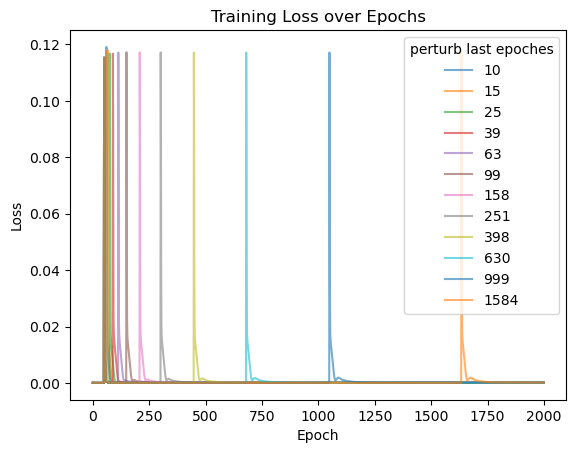

In [57]:
# Plotting the loss
for i, simu_losses in enumerate(all_simu_losses):
    plt.plot(range(simu_epochs), simu_losses, label=perturb_lasts[i], alpha=0.6)
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim([0,0.02])
# plt.xlim([0,200])
plt.title('Training Loss over Epochs')
plt.legend(title='perturb last epoches')
# plt.savefig('fig/0122_abb05_perturb_loss.png')
plt.show()

In [58]:
recover_costs = []
recover_epochs = []
for k in range(len(all_simu_losses)):
    simu_losses = all_simu_losses[k]
    perturb_last = perturb_lasts[k]
    perturb_start = 50
    origin_start = perturb_start + perturb_last

    recover_cost = 0
    recover_epoch = 0
    for i, loss in enumerate(simu_losses):
        if i > origin_start:
            if loss < 0.0001:
                break
            if loss < 1:
                recover_cost += loss
                recover_epoch += 1

    print(recover_cost)
    print(recover_epoch)
    recover_costs.append(recover_cost)
    recover_epochs.append(recover_epoch)

0.2826643111984595
67
0.2950960233793012
62
0.32071349601756083
92
0.34514641600253526
155
0.37217669045639923
234
0.3767635530239204
203
0.3888809963827953
232
0.3994738893234171
240
0.412413627767819
265
0.4193846377165755
250
0.423432014977152
243
0.4249624714793754
239


Text(0.5, 1.0, 'Gain Change over Epochs')

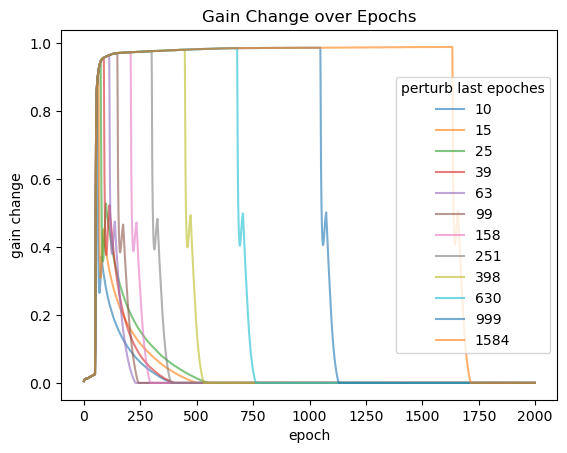

In [59]:
for i, gain_changes in enumerate(all_gain_changes):
    plt.plot(np.arange(simu_epochs), gain_changes, label=perturb_lasts[i], alpha=0.6)
plt.xlabel("epoch")
plt.ylabel("gain change")
plt.legend(title='perturb last epoches')
plt.title('Gain Change over Epochs')
# plt.savefig('fig/0122_abb05_perturb_gc.png')

Text(0.5, 1.0, 'Shift Change over Epochs')

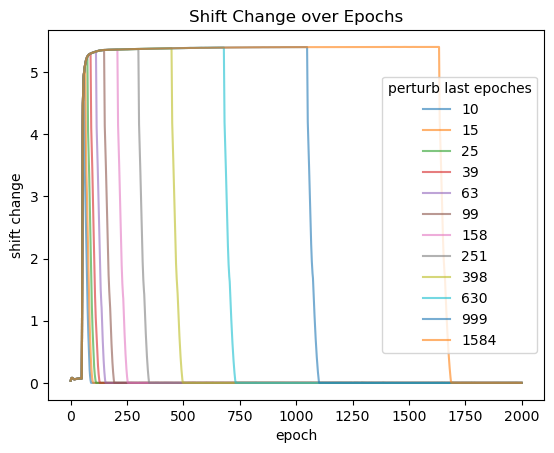

In [60]:
for i, shift_changes in enumerate(all_shift_changes):
    plt.plot(np.arange(simu_epochs), shift_changes, label=perturb_lasts[i], alpha=0.6)
plt.xlabel("epoch")
plt.ylabel("shift change")
plt.legend(title='perturb last epoches')
plt.title('Shift Change over Epochs')
# plt.savefig('fig/0122_abb05_perturb_sc.png')

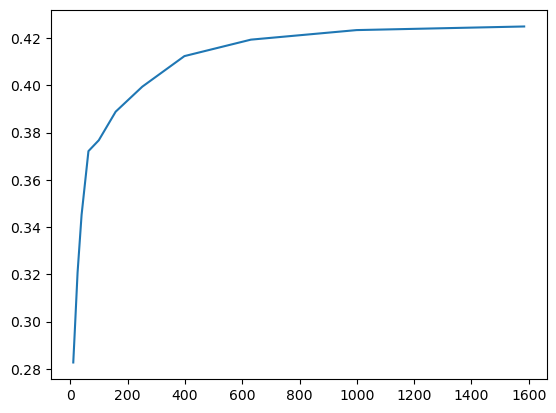

In [61]:
plt.plot(perturb_lasts, recover_costs)

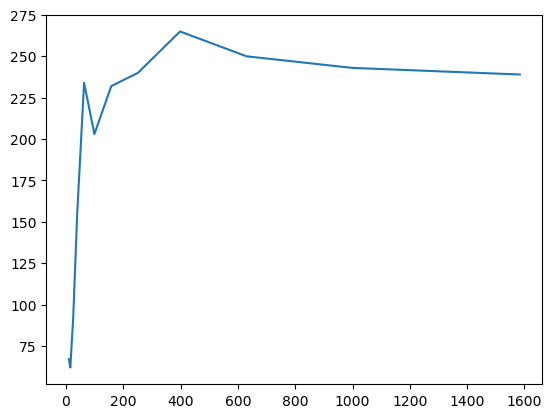

In [62]:
plt.plot(perturb_lasts, recover_epochs)